In [1]:
import scipy.linalg as la
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import numpy as np
from helper_functions.grape_functions import *
from main_grape.Grape import Grape
%pylab inline



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
qubit_num = 2


#Defining time scales
total_time = qubit_num *12.0
steps = qubit_num * 300



state_transfer = False
#Defining H0
qubit_state_num = 2
freq_ge = 3.9#GHz
g = 2*np.pi*0.5 #GHz

ens = np.array([ 2*np.pi*ii*(freq_ge) for ii in np.arange(qubit_state_num)])
Q_x   = np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1)
Q_y   = (0+1j) *(np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)-np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1))
Q_z   = np.diag(np.arange(0,qubit_state_num))
I_q = np.identity(qubit_state_num)
H_q = np.diag(ens)

X = multi_kron(Q_x,qubit_num)
Z = multi_kron(Q_z,qubit_num)
Y = multi_kron(Q_y,qubit_num)

g_op = nn_chain_kron(Q_x, I_q, qubit_num, qubit_state_num)

#g_op_test = np.kron(np.kron(np.kron(Q_x,Q_x),I_q),I_q) + np.kron(np.kron(np.kron(I_q,Q_x),Q_x),I_q) + np.kron(np.kron(np.kron(I_q,I_q),Q_x),Q_x)
#print np.allclose(g_op, g_op_test)

H0 = kron_all(H_q,qubit_num, I_q) + g * g_op

# Defining dressed info
is_dressed = True
w_c, v_c, dressed_id = get_dressed_info(H0)
dressed_info = {'dressed_id':dressed_id, 'eigenvectors':v_c, 'eigenvalues':w_c,'is_dressed':is_dressed}


#Defining Concerned states (starting states)

psi0 = concerned(qubit_num,qubit_state_num)


#Defining states to include in the drawing of occupation
states_draw_list = range(qubit_state_num**qubit_num)
states_draw_names =[]
for ii in states_draw_list:
    states_draw_names.append(Basis(ii,qubit_num,qubit_state_num))
#Defining U (Target)

if is_dressed:
    #U = np.zeros([qubit_num**qubit_state_num,qubit_num**qubit_state_num])
    #for ii in range(qubit_num**qubit_state_num):
        #dressed_vec = np.zeros(qubit_num**qubit_state_num)
        #vec = qft(qubit_num)[ii]
        #for jj in range(qubit_num**qubit_state_num):
            #dressed_vec = dressed_vec + vec[jj]* v_c[:,get_state_index(jj,dressed_id)]
        #print dressed_vec
        #U =  U + np.outer(dressed_vec,v_c[:,get_state_index(ii,dressed_id)])
    
    U = dressed_unitary(transmon_gate(qft(qubit_num),qubit_state_num),v_c,dressed_id)

else:   
    U= transmon_gate(qft(qubit_num),qubit_state_num)



#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num**qubit_num)
U0= q_identity

#Defining control Hs

Hops = []
Hnames = []
ops_max_amp = []
Hops,Hnames,ops_max_amp = append_separate_krons(Q_x,'x',qubit_num,qubit_state_num,Hops,Hnames,ops_max_amp,amp=4.0)
Hops,Hnames,ops_max_amp = append_separate_krons(Q_z,'z',qubit_num,qubit_state_num,Hops,Hnames,ops_max_amp,amp=4.0)

print Hnames

#Defining convergence parameters
max_iterations = 2000
decay = 500 #max_iterations/2
convergence = {'rate':0.10, 'update_step':50, 'max_iterations':max_iterations,\
               'conv_target':1e-3,'learning_rate_decay':decay,'min_grad':1e-60}

reg_coeffs = {'envelope':0,'dwdt':0,'d2wdt2':0}

#print np.dot(U,v_c[:,get_state_index(1,dressed_id)])
#print v_c[:,get_state_index(0,dressed_id)]
#print v_c[:,get_state_index(1,dressed_id)]
#print v_c[:,get_state_index(2,dressed_id)]
#print v_c[:,get_state_index(3,dressed_id)]
#print np.dot(qft(2),[0,1,0,0])
#print np.transpose(qft(2))[1]
#print 0.5*(v_c[:,get_state_index(0,dressed_id)]+v_c[:,get_state_index(1,dressed_id)]-v_c[:,get_state_index(2,dressed_id)]-v_c[:,get_state_index(3,dressed_id)])

['xi', 'ix', 'zi', 'iz']


In [3]:
#import h5py

#with h5py.File('/home/nelson/Simulations/GRAPE-Data/spin_chain_ghz/00000_spin_chain_ghz_N8.h5','r') as hf:
#    u0 = np.array(hf.get('uks'))[31]

u0 = None

Error = :2.92e-04; Runtime: 69.0s; grads =   2.158e-03, unitary_metric = 1.00001


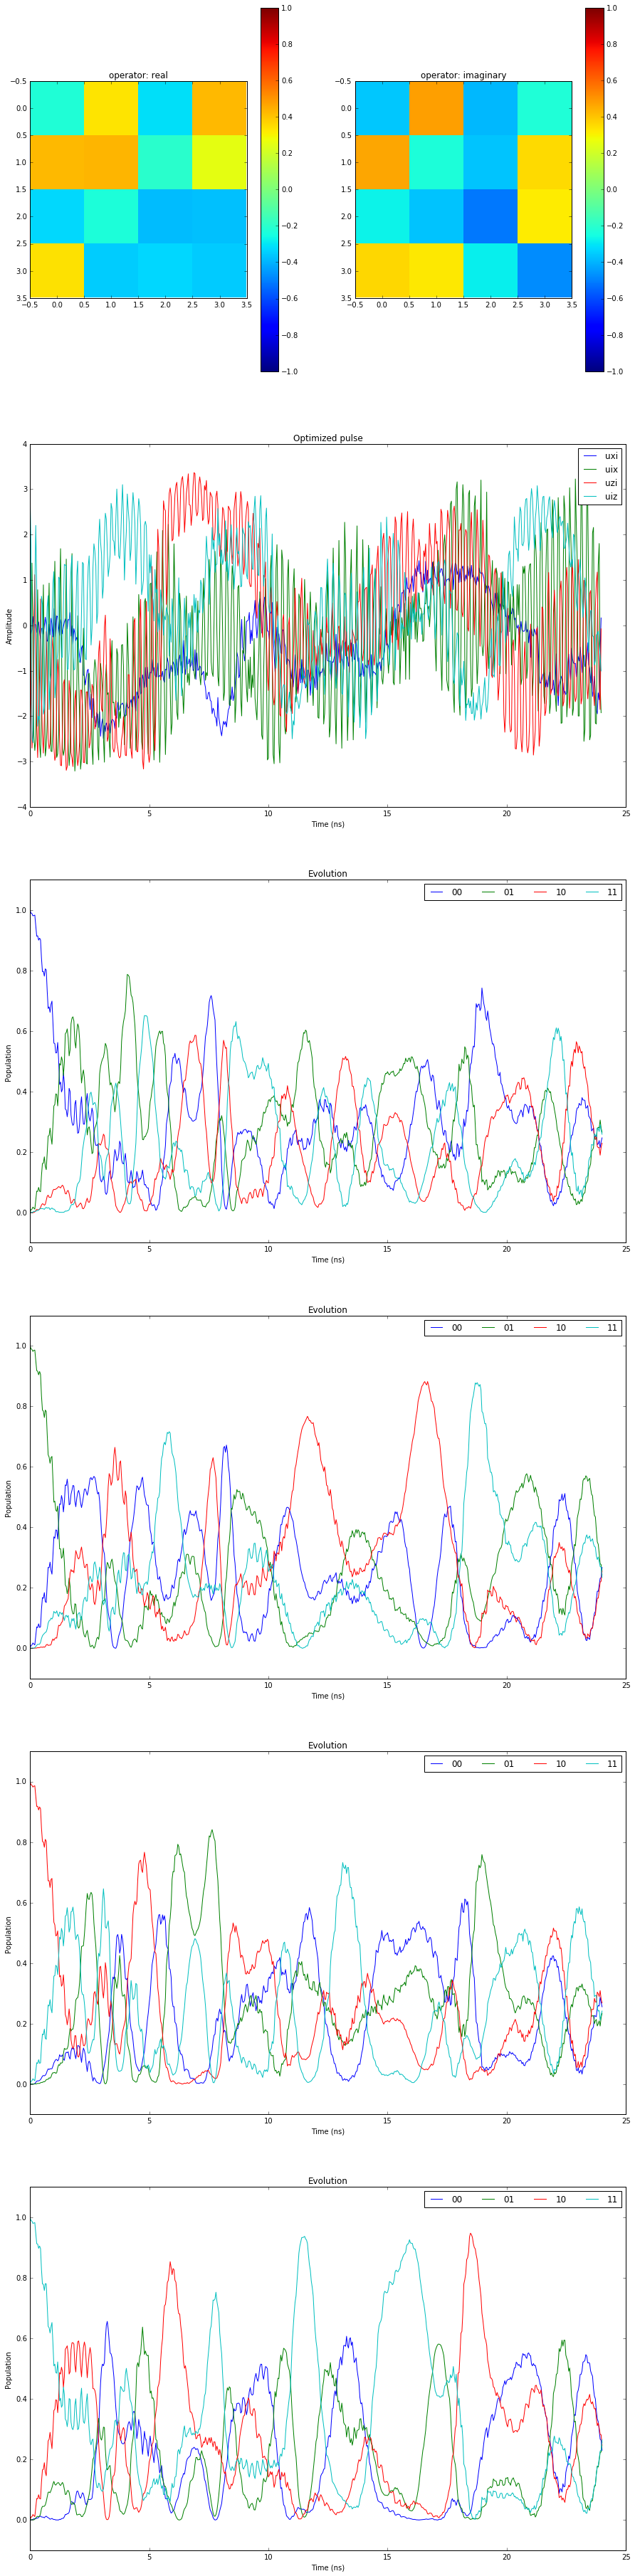

In [4]:
 #Extra options
#reg_coeffs = reg_coeffs,draw = [states_draw_list,states_draw_names] ,forbidden = states_forbidden_list,multi_mode = multi_mode,
#maxA = ops_max_amp,use_gpu = True

uks,U_final = Grape(H0,Hops,Hnames,U,total_time,steps,psi0,convergence=convergence, draw = [states_draw_list,states_draw_names],  
                    
                    show_plots = False, use_gpu = True, 
       unitary_error = 1e-8, switch = False,  maxA=ops_max_amp,no_scaling = True, Taylor_terms =[14,0],
                   dressed_info = dressed_info, method = 'Adam', reg_coeffs=reg_coeffs, file_name='nk_spinn_chain_qft_N%d' %(qubit_num), 
                    data_path = '/home/nelson/Simulations/GRAPE-Data/spin_chain_qft')
      
      